# $$\text{PI - like:}$$

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
#plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 8)
colors = ['C0', 'C1', 'C2', 'C4', 'C5', 'y']

### $$\text{Definição do sistema em espaço de estados:}$$

In [2]:
A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 2, -1]
])

B = np.array([0, 0, 1])[:, np.newaxis]

C = np.array([10, 1, 0])

### $$\text{Projeto dos ganhos do PI-like:}$$

In [3]:
#Definição dos polos desejados:
pd = np.array([-10, -80, (-8+8j)], dtype=np.complex_)

#Definição das matrizes aumentadas:
Atil = np.block([[A, np.zeros((len(A),1))], [-C, np.array([0])]])
Btil = np.vstack((B, np.array([0])))

#Organizando os polos na matriz modal:
modals = []
order = 0
for i in range(len(pd)):
    if(pd[i].imag == 0):
        modals.append([pd[i].real])
        order += 1
    else:
        modals.append([pd[i].real, pd[i].imag])
        order += 2
F = np.zeros((order, order))
for i in range(len(modals)):
    if(len(modals[i])==1):
        F[i][i] = modals[i][0]
    else:
        F[i][i] = modals[i][0]
        F[i][i+1] = -modals[i][1]
        F[i+1][i] = modals[i][1]
        F[i+1][i+1] = modals[i][0]

#Arbitrar ktil:
ktil = np.ones(len(Atil))

#Encontrar a matriz de transformação de base:
T = ct.lyap(Atil, -F, -Btil*ktil)

k = ktil@np.linalg.inv(T)

k

array([ 14080.,   2370.,    105., -10240.])

### $$\text{Interconexão da malha fechada:}$$

In [6]:
#Sistema:
stateslabels = ['y']
for i in range(len(A)):
    stateslabels.append(f'x{i+1}')
G = ct.ss(A,B,np.vstack((C, np.identity(len(A)))),np.zeros((len(A)+1, 1)), inputs=['u'], outputs=stateslabels)

#Somador que gera o sinal de erro:
some = ct.summing_junction(inputs=['r', '-y'], output='e')

#Realimentação dos estados:
K = []
kxl = []
for i in range(len(k)-1):
    current_kxl = f'kx{i+1}'
    K.append(ct.tf((-k[i]), (1), inputs=f'x{i+1}', outputs=current_kxl))
    kxl.append(current_kxl)

#Ramo integrador:
Gi = ct.tf([1], [1, 0], inputs='e', outputs='xa')
ka = ct.tf((-k[-1]), (1), inputs='xa', outputs='kaxa')
kxl.append('kaxa')

#Adicionando a entrada de perturbação:
kxl.append('d')

#Somador que gera o sinal de controle:
somu = ct.summing_junction(inputs=kxl, output='u')

#Interconnect:
componentes = [G, Gi, ka, somu, some]
componentes.extend(K)
out = ['u']
out.extend(stateslabels)
out.append('xa')
L = ct.interconnect(componentes, inputs=['r', 'd'], outputs=out)

### $$\text{Simulação do sistema:}$$

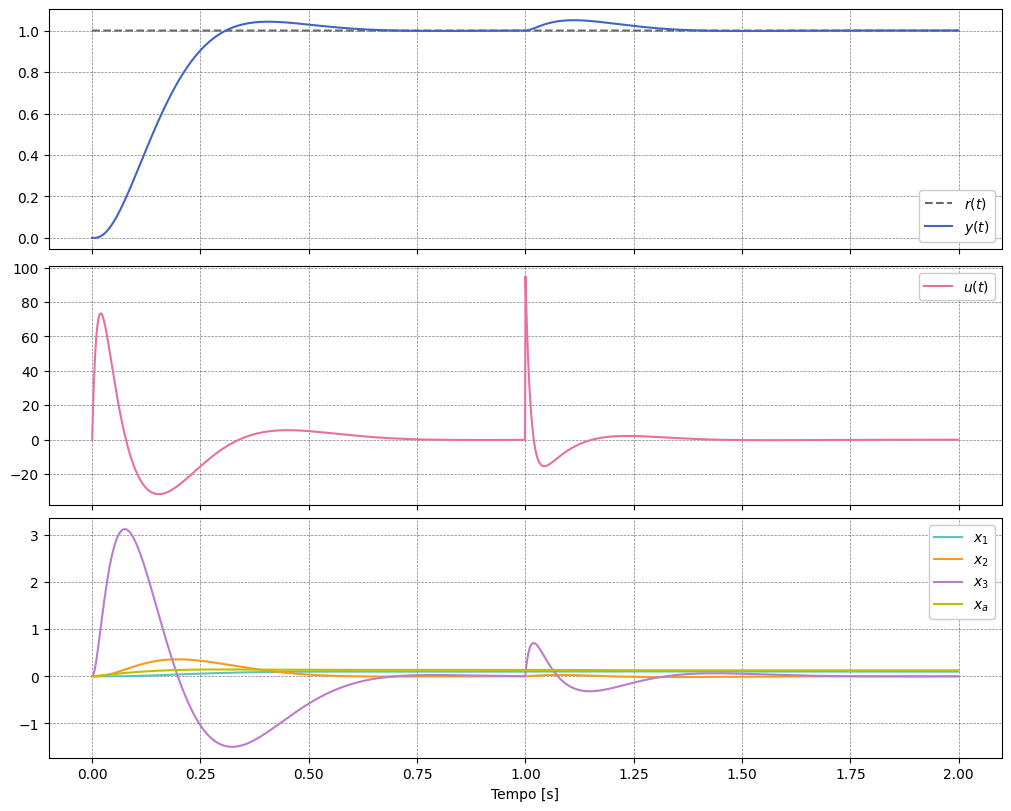

In [8]:
#Vetor de tempo:
ts = 1e-3
tdeg = 1
t = np.arange(0, 2*tdeg, ts)

#Vetor de referência:
r = np.ones(int(2*tdeg/ts))*1

#Perturbação no sistema
d = np.hstack([np.zeros(int(tdeg/ts)), np.ones(int(tdeg/ts))*100])

#Simulação do sistema:
t, sol = ct.forced_response(L, t, [r, d])

#Demultiplex da saída:
u = sol[0]
y = sol[1]
x = sol[2:]

#Plot das curvas:
labels = []
for i in range(len(x)-1):
    labels.append(f'$x_{i+1}$')
labels.append('$x_a$')
plt.subplots(3, 1, sharex=True, constrained_layout = True)
plt.subplot(3, 1, 1)
plt.plot(t, r, color='C3', linestyle='dashed', label='$r(t)$')
plt.plot(t, y, color='C0', label='$y(t)$')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, u, color='C1', label='$u(t)$')
plt.legend()
plt.subplot(3, 1, 3)
for i in range(len(x)):
    plt.plot(t, x[i], color=colors[i+2], label=labels[i])
plt.xlabel('Tempo [s]')
plt.legend()
plt.show()

In [ ]:
ct.poles(L)